In [6]:
from diffusers import DDPMScheduler, UNet2DModel

scheduler = DDPMScheduler.from_pretrained('google/ddpm-celebahq-256')
model = UNet2DModel.from_pretrained('google/ddpm-celebahq-256', use_safetensor=True)

An error occurred while trying to fetch google/ddpm-celebahq-256: google/ddpm-celebahq-256 does not appear to have a file named diffusion_pytorch_model.safetensors.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.


the schedular determines the steps and strategies for denoising. The pipeline integrates multiple components

In [15]:
scheduler.set_timesteps(15)
scheduler.timesteps

tensor([924, 858, 792, 726, 660, 594, 528, 462, 396, 330, 264, 198, 132,  66,
          0])

In [16]:
import torch

sample_size = model.config.sample_size
noise = torch.randn((1, 3, sample_size, sample_size))

In [17]:
input = noise

for t in scheduler.timesteps:
    with torch.no_grad():
        noisy_residual = model(input, t).sample
    previous_noisy_sample = scheduler.step(noisy_residual, t, input).prev_sample
    input = previous_noisy_sample

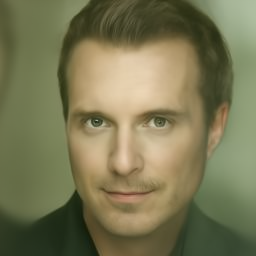

In [18]:
from PIL import Image
import numpy as np

image = (input / 2 + 0.5).clamp(0, 1).squeeze()
image = (image.permute(1, 2, 0) * 255).round().to(torch.uint8).cpu().numpy()
image = Image.fromarray(image)
image